In [1]:
import sys, time, os
from pathlib import Path
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from bmi_topography import Topography
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from landlab.components import FlowAccumulator, PriorityFloodFlowRouter, ChannelProfiler, BedrockLandslider, SpaceLargeScaleEroder
from landlab.io import read_esri_ascii, write_esri_ascii
from landlab.io.netcdf import read_netcdf
from landlab.utils import get_watershed_mask

# [SPACE large-scale](https://landlab.readthedocs.io/en/latest/reference/components/space.html#module-landlab.components.space.space_large_scale_eroder)

In [42]:
num_rows = 20
num_columns = 20
node_spacing = 100.0
mg = RasterModelGrid((num_rows, num_columns), xy_spacing=node_spacing)

In [43]:
node_next_to_outlet = num_columns + 1
np.random.seed(seed=5000)
_ = mg.add_zeros("topographic__elevation", at="node")

_ = mg.add_zeros("soil__depth", at="node")
mg.at_node["soil__depth"][mg.core_nodes] = 2.0

_ = mg.add_zeros("bedrock__elevation", at="node")
mg.at_node["bedrock__elevation"] += (
    mg.node_y / 10. + mg.node_x / 10. + np.random.rand(len(mg.node_y)) / 10.
)
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)

mg.set_watershed_boundary_condition_outlet_id(
    0, mg.at_node['topographic__elevation'], -9999.0
)

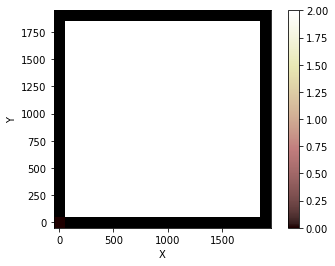

In [47]:
_ = imshow_grid(mg, "soil__depth")


In [45]:
flood_router = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)
space = SpaceLargeScaleEroder(
    mg,
    K_sed=0.01, # erodibility for sediment
    K_br=0.001, # erodibility for bedrock
    F_f=0.0, # 
    phi=0.0,
    H_star=1.0,
    v_s=5.0,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

In [46]:
timestep = 10.0
elapsed_time = 0.0
count = 0
run_time = 1e4
sed_flux = np.zeros(int(run_time // timestep))

In [34]:
while elapsed_time < run_time:
    flood_router.run_one_step()
    _ = space.run_one_step(dt=timestep)
    sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
    elapsed_time += timestep
    count += 1

In [35]:
flood_router.run_one_step()
_ = space.run_one_step(dt=timestep)
sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
elapsed_time += timestep
count += 1

IndexError: index 1000 is out of bounds for axis 0 with size 1000

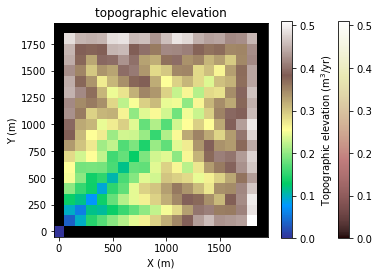

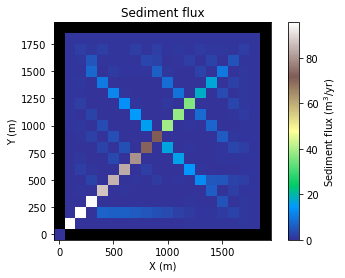

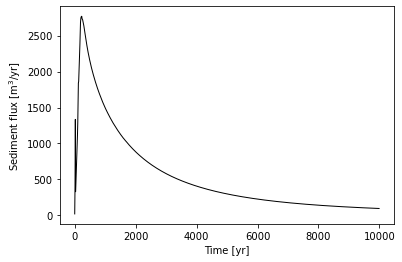

In [40]:
fig = plt.figure()
plot = plt.subplot()
_ = imshow_grid(
    mg,
    "topographic__elevation",
    plot_name="topographic elevation",
    var_name="Topographic elevation",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
_ = plt.figure()
_ = imshow_grid(
    mg,
    "sediment__flux",
    plot_name="Sediment flux",
    var_name="Sediment flux",
    var_units=r"m$^3$/yr",
    grid_units=("m", "m"),
    cmap="terrain",
)
fig = plt.figure()
sedfluxplot = plt.subplot()
_ = sedfluxplot.plot(np.arange(len(sed_flux)) * timestep, sed_flux, color="k", linewidth=1.0)
_ = sedfluxplot.set_xlabel("Time [yr]")
_ = sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/yr]")



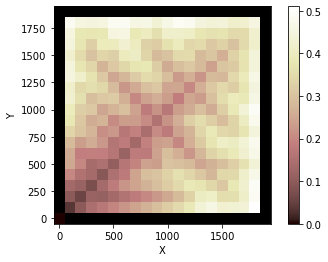

In [41]:
_ = imshow_grid(mg, "soil__depth")
